# Testing Backends

This notebook demonstrates quantum reservoir computing on various backend setups.

---

This file is part of the `QuantumReservoirPy` project.

Last Updated: `2023-09-18`

Using Version: `0.1`

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit.providers.fake_provider import Fake5QV1
from qiskit.quantum_info import random_unitary
from qiskit_aer import AerSimulator

from quantumreservoirpy.reservoirs import QReservoir, Static

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

We will test the following backend setups:
* State-based
* Shot-based
* Incorporating noise

We will use a randomly-generated unitary for all setups. See [1Qbit.ipynb](./1Qbit.ipynb) for a similar example.

##### Common Variables

In [2]:
sequence = [0, 1, 0] * 30 # Feel free to play around with this and see how your results change

num_qubits = 4
operator = random_unitary(2 ** num_qubits, seed=416)

ideal_backend = AerSimulator()

**Note:** Some random unitaries work well, and some do not. Finding out why is not the purpose of this notebook, so you may need to try a few seeds to get good results.

---

## State-Based Processing

We will make use of the `save_probabilities` function provided by the Qiskit Aer circuit simulator to generate the distribution we would theoretically expect. Alternatively, we could use the `save_statevector` function for a similar result, but this would require working with complex values.

The pre-built `Static` and `Incremental` reservoirs assume a shot-based method, so we inherit from the `QReservoir` class. Since we our only dealing with a single shot in this case, this simplifies our `run` and `predict` methods.

In [3]:
class StatevectorReservoir(QReservoir):

    def before(self, circuit):
        circuit.h(circuit.qubits)
        self.counter = 0 # We need to give each measured probability a label
    
    def during(self, circuit, timestep, reservoirnumber):
        circuit.save_probabilities(qubits=[0], label=str(self.counter))
        self.counter += 1
        circuit.initialize(str(timestep), 0)
        circuit.append(operator, circuit.qubits)
    
    def run(self, timeseries, **kwargs):
        circuit = self.circuit(timeseries, merge_registers=False).reverse_bits()
        results = self.backend.run(circuit, memory=True, **kwargs)
        probabilities = sorted(results.result().data(0).items(), key = lambda x : int(x[0]))
        return np.array([[item[1][0]] for item in probabilities])
    
    def predict(self, num_pred, model, from_series, **kwargs):
        max_len_predictions = len(from_series) + min(num_pred, self.memory)

        predictions = np.zeros(max_len_predictions)
        predictions[:len(from_series)] = from_series

        for i in range(len(from_series), max_len_predictions):
            states = self.run(predictions[:i][-max_len_predictions:],  kwargs=kwargs)
            pred_state = states[-1].reshape((1, -1))
            predictions[i] = model.predict(pred_state)
            self.last_state = pred_state.ravel()

        return predictions[-num_pred:]
    

Create and run the reservoir on the timeseries.

In [4]:
state_res = StatevectorReservoir(n_qubits=num_qubits, backend=ideal_backend)
state_data = state_res.run(timeseries=sequence)

We will do the plotting and analysis later, for sake of comparison.

---

## Shot-Based Processing

This is much like earlier examples which you may have already seen. We will inherit from the `Static` reservoir.

In [5]:
class ShotReservoir(Static):

    def before(self, circuit):
        circuit.h(circuit.qubits)
    
    def during(self, circuit, timestep, reservoirnumber):
        circuit.measure(0)
        circuit.initialize(str(timestep), 0)
        circuit.append(operator, circuit.qubits)
    

Create and run the reservoir on the same timeseries.

In [6]:
shot_res = ShotReservoir(n_qubits=num_qubits, backend=ideal_backend)
shot_data = shot_res.run(timeseries=sequence, shots=10000)

Running reservoirs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.53s/it]


---

## Noisy Processing

To add noise to our shot-based reservoir, we can use a 5 qubit system.

In [7]:
noisy_backend = Fake5QV1()

noisy_res = ShotReservoir(n_qubits=num_qubits, backend = noisy_backend)
noisy_data = noisy_res.run(timeseries=sequence, shots=10000)

Running reservoirs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:07<00:00, 187.78s/it]


---

## Results

Plotting the data from each model, we get the following results.

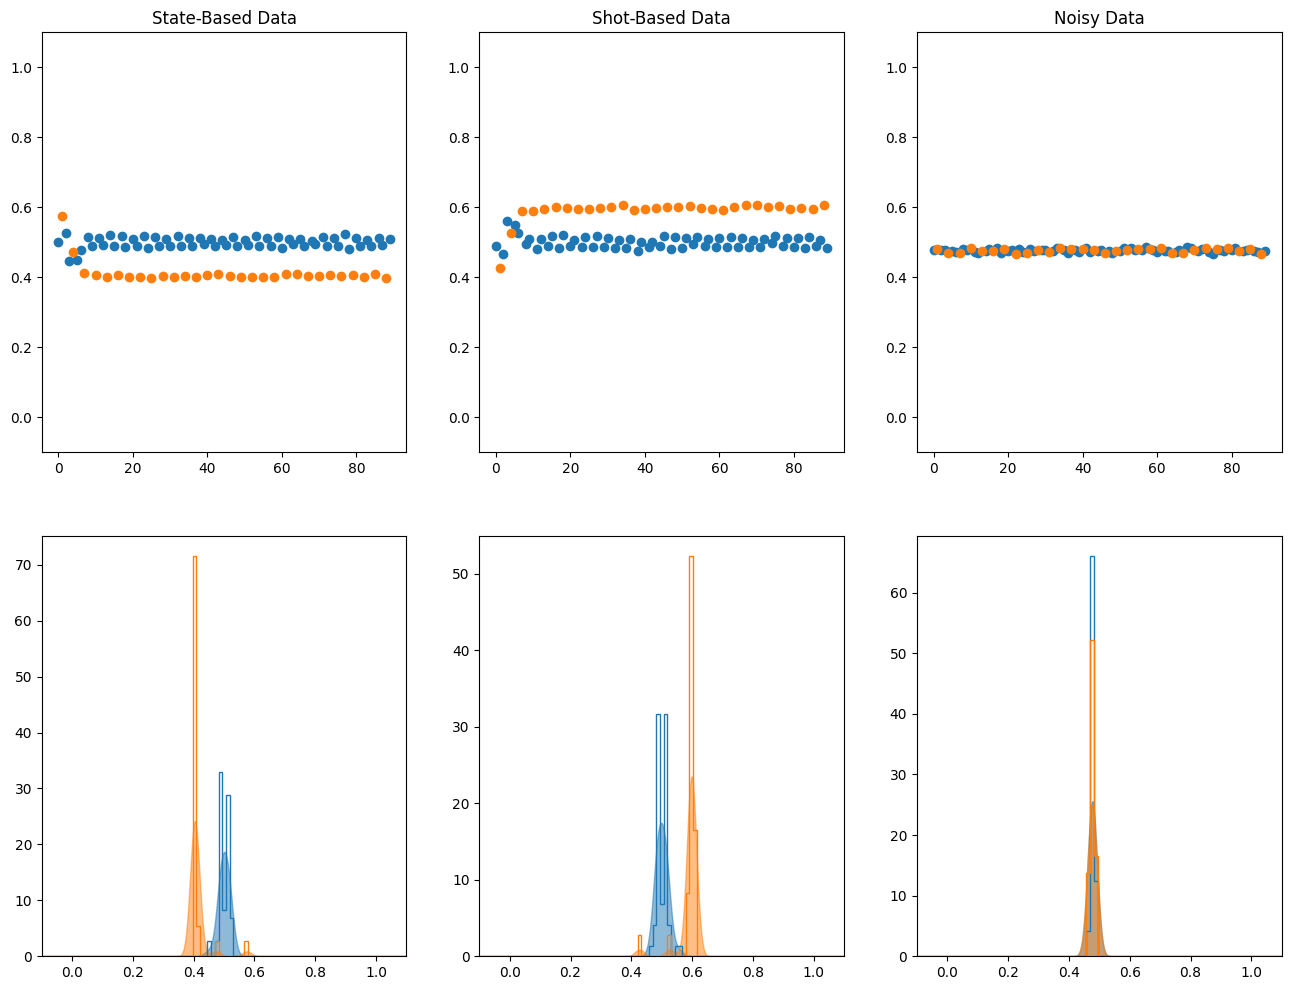

In [8]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(16, 12)

titles = ["State-Based Data", "Shot-Based Data", "Noisy Data"]

for i, data in enumerate([state_data, shot_data, noisy_data]):
    axs[0, i].set_title(titles[i])
    x_plot = np.linspace(-0.5, 1.5, 10000, endpoint=True)

    for j, category in enumerate(np.unique(sequence)):
        colour = "C" + str(j)
        matches = category == sequence

        axs[0, i].plot(np.arange(len(data))[matches], data[matches], marker='o', lw=0, color=colour)
        axs[0, i].set_ylim(-0.1, 1.1)

        axs[1, i].hist(
            data[matches],
            density=True,
            bins=np.linspace(-0.1, 1.1, 100, endpoint=True),
            histtype='step',
            color=colour
        )
        kde = KernelDensity(bandwidth=1.5e-2, kernel='gaussian')
        kde.fit(data[matches].reshape(-1, 1))
        logprob = kde.score_samples(x_plot.reshape(-1, 1))
        axs[1, i].fill_between(x_plot, np.exp(logprob), alpha=0.5, color=colour)
        axs[1, i].set_xlim(-0.1, 1.1)

plt.show()

The structure of our reservoir and our selected random unitary initially appears to work well for simulated data with an ideal quantum processor. However, the noise model for `ibmq_toronto` overshadows any possible distinction.

We can train a SVM on each set of data and evaluate its fit.

In [9]:
def evaluate_svc_fit(data, warmup):
    x = data.reshape(-1, 1)[warmup:]
    y = sequence[warmup:]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

    clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='linear'))
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

for i, data in enumerate([state_data, shot_data, noisy_data]):
    print("Fit of", titles[i], ':', evaluate_svc_fit(data, 10))

Fit of State-Based Data : 1.0
Fit of Shot-Based Data : 1.0
Fit of Noisy Data : 0.7037037037037037


These values agree with our plots.